In [1]:
%matplotlib inline

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [2]:
plt.rcParams['figure.figsize'] = [16, 5]

## 1. Classifier training

In [3]:
galaxies = pd.read_csv("data_gama_gal_orient.txt", sep="\s+")
galaxies["baslot"] = galaxies["ba"].multiply(100).apply(np.ceil) - 1
galaxies.describe()

,rmag,rabsmag,redshift,rad,sern,pos,ba,baslot
count,113379.000000,113379.000000,113379.000000,113379.000000,113379.000000,113379.000000,113379.000000,113379.000000
mean,18.849054,-20.695499,0.183236,3.377715,2.195855,-0.113890,0.598803,59.374558
std,0.761111,1.067364,0.068758,1.134358,1.626806,52.259381,0.217319,21.732715
min,13.752200,-23.627300,0.020004,1.198020,0.012100,-89.998400,0.001900,0.000000
25%,18.435400,-21.401300,0.131304,2.538515,0.956600,-45.688350,0.430900,43.000000
50%,19.030700,-20.879700,0.182052,3.129540,1.657800,-0.156400,0.618500,61.000000
75%,19.445600,-20.153850,0.243140,3.991835,3.041950,45.516700,0.777200,77.000000
max,19.800000,-15.050800,0.299999,7.298490,9.991900,89.999900,1.000000,99.000000


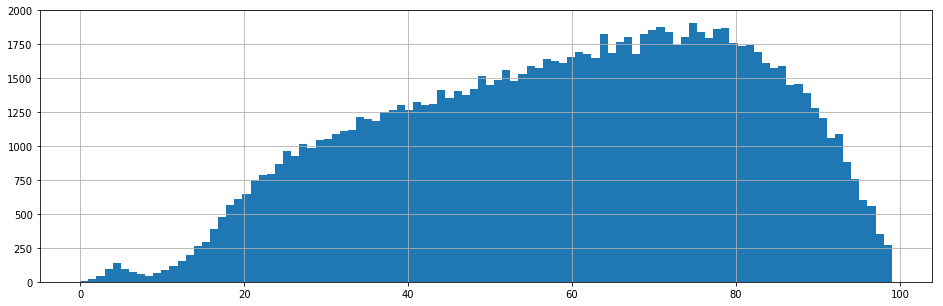

In [4]:
galaxies["baslot"].hist(bins=100)

### 1.1 Generate training set (75%) and test set (25%)

In [5]:
training_set = np.random.rand(len(galaxies)) < 0.75
galaxies_train = galaxies[training_set]
galaxies_test = galaxies[~training_set]

parameters = ["rmag", "rabsmag", "redshift", "rad", "sern"]

X_train = galaxies_train[parameters].values
Y_train = galaxies_train["baslot"].values

X_test = galaxies_test[parameters].values
Y_test = galaxies_test["baslot"].values

len(X_train), len(X_test)

(85056, 28323)

### 1.2 Train Random Forest Classifier

In [6]:
start = time.time()

clf = RandomForestClassifier(
    n_estimators=64,
    #max_depth=10,
    #min_samples_split=5,
    min_samples_leaf=50,
    max_features=None,
    n_jobs=-1
)

clf.fit(X_train, Y_train)

end = time.time()

end - start

9.592813491821289

### 1.3 Performance

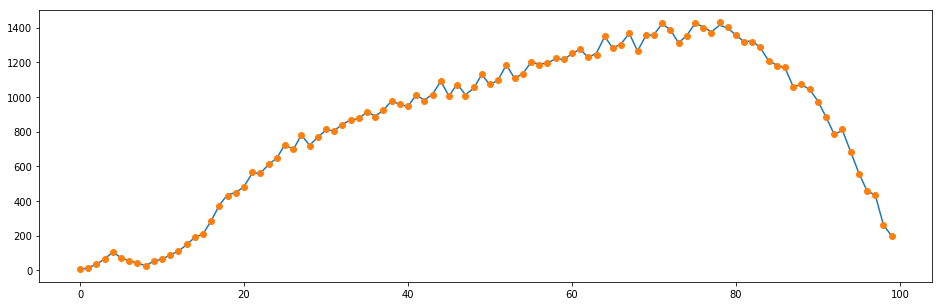

In [7]:
plt.plot(np.sum(clf.predict_proba(X_train), 0))
plt.plot(np.histogram(Y_train, 100, (0, 100))[0], 'o')

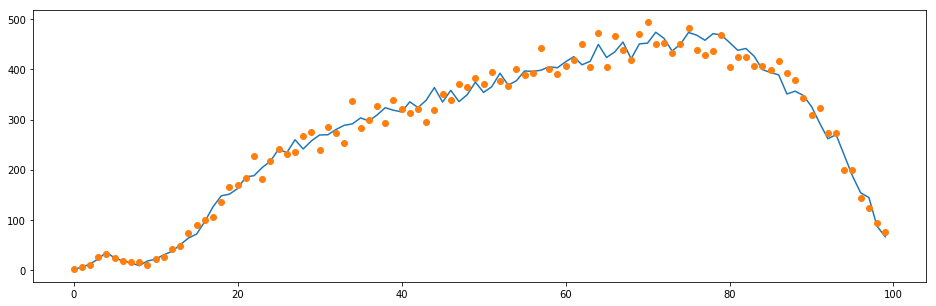

In [8]:
plt.plot(np.sum(clf.predict_proba(X_test), 0))
plt.plot(np.histogram(Y_test, 100, (0, 100))[0], 'o')

## 2. Classifier tests

In [9]:
def compare_hist(galaxies, parameter, cuts):
    quantiles = pd.qcut(galaxies[parameter], cuts, labels=False)

    for i in range(len(cuts) - 1):
        hist = np.histogram(galaxies[quantiles == i]["baslot"].values, 100, (0, 100))[0]
        color = next(plt.gca()._get_lines.prop_cycler)['color']
        
        plt.plot(hist, 'o', color=color, label="("+str(round(cuts[i], 2))+", "+str(round(cuts[i+1], 2))+"]")
        plt.plot(np.sum(clf.predict_proba(galaxies[quantiles == i][parameters].values), 0), color=color)
        
        plt.title(parameter)
        plt.gca().legend()

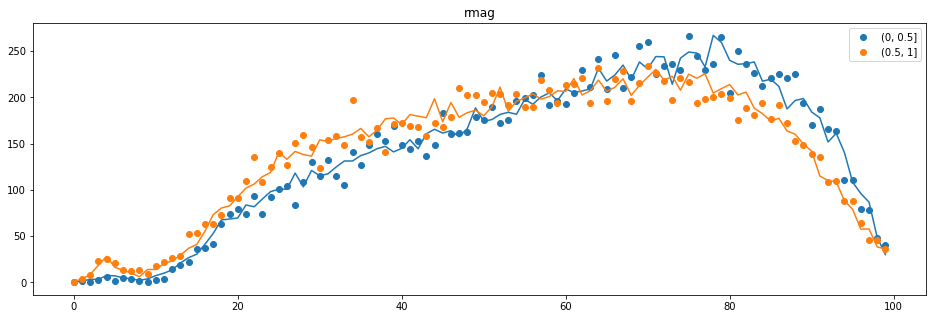

In [10]:
compare_hist(galaxies_test, "rmag", (0, 1/2, 1))

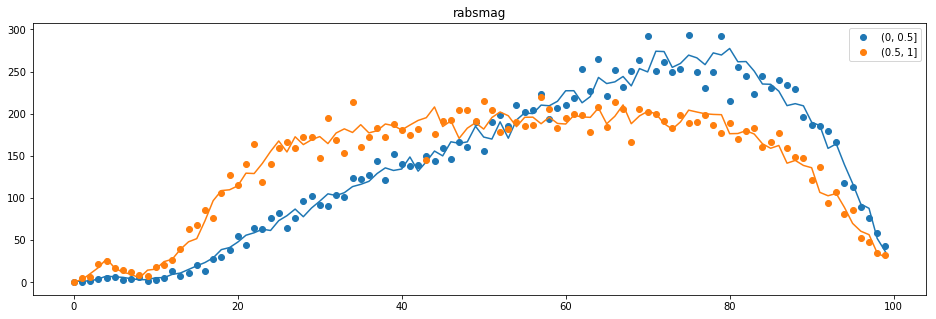

In [11]:
compare_hist(galaxies_test, "rabsmag", (0, 1/2, 1))

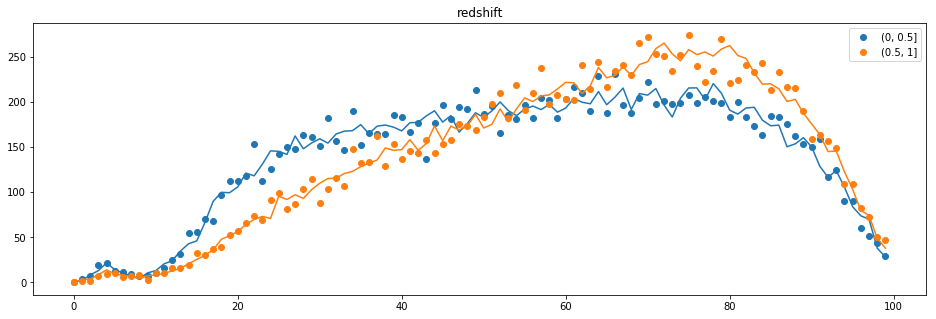

In [12]:
compare_hist(galaxies_test, "redshift", (0, 1/2, 1))

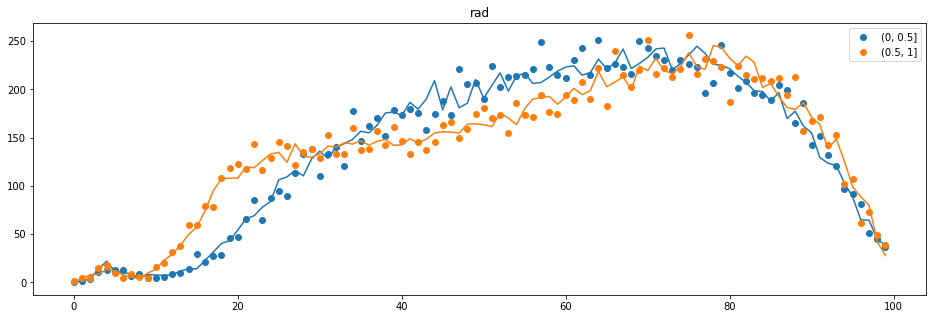

In [13]:
compare_hist(galaxies_test, "rad", (0, 1/2, 1))

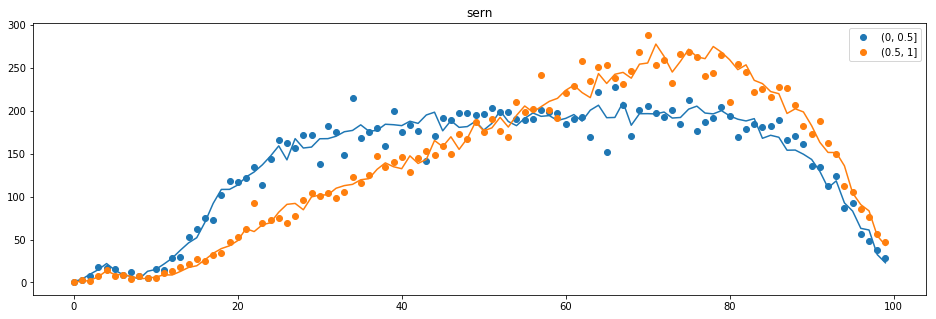

In [14]:
compare_hist(galaxies_test, "sern", (0, 1/2, 1))

## 3. Flatness estimation

In [249]:
def get_best_estimator(Estimator, bounds, target, epsilon, density=5, max_iterations=10):
    x = [np.linspace(b[0], b[1], density) for b in bounds]
    grid = np.array(np.meshgrid(x[0], x[1])).T.reshape(-1, 2)
    
    best_x = None
    best_estimator = None
    
    for x in grid:
        estimator = Estimator(x)
        estimator.error = estimator.fit(target)
        
        if best_estimator == None or estimator.error < best_estimator.error:
            best_x = x
            best_estimator = estimator
    
    if max_iterations > 0:
        done = True
        new_bounds = []

        for i, x in enumerate(best_x):
            step = (bounds[i][1] - bounds[i][0])/density
            
            if step > epsilon[i]:
                done = False

            new_bounds.append([
                max(bounds[i][0], x - step),
                min(bounds[i][1], x + step)
            ])

        if not done:
            return get_best_estimator(Estimator, new_bounds, target, epsilon, density, max_iterations - 1)
    
    return best_estimator

class FlatnessEstimator(object):
    mean = 0.5
    deviation = 0
    
    def __init__(self, x):
        self.mean = x[0]
        self.deviation = x[1]

    def fit(self, target):
        error = 0
        
        for i in range(10):
            error += np.sum(np.square((target - self.abhist())))
        
        return error/10
    
    def abhist(self, size=10000):
        cos = np.random.uniform(0, 1, size)
        f = np.random.normal(self.mean, self.deviation, size)
        abslot = np.ceil((np.sqrt(cos**2 * (1 - f**2) + f**2)) * 100) - 1
        abhist = np.histogram(abslot, 100, (0, 100), density=True)[0]
        
        return abhist

def get_flatness(target):
    return get_best_estimator(FlatnessEstimator, ((0, 1), (0, 1)), target, (0.01, 0.01))

In [250]:
def compare_flatness_hist(galaxies, parameter, cuts):
    quantiles = pd.qcut(galaxies[parameter], cuts, labels=False)

    for i in range(len(cuts) - 1):
        hist = np.histogram(galaxies[quantiles == i]["baslot"].values, 100, (0, 100), density=True)[0]
        color = next(plt.gca()._get_lines.prop_cycler)['color']
        flatness = get_flatness(hist)
        
        plt.plot(hist, 'o', color=color, label="("+str(round(cuts[i], 2))+", "+str(round(cuts[i+1], 2))+"]")
        plt.plot(flatness.abhist(100000), color=color, label=("f ~ N(%.2f, %.2f)" % (flatness.mean, flatness.deviation)))
        
        plt.title(parameter)
        plt.gca().legend()

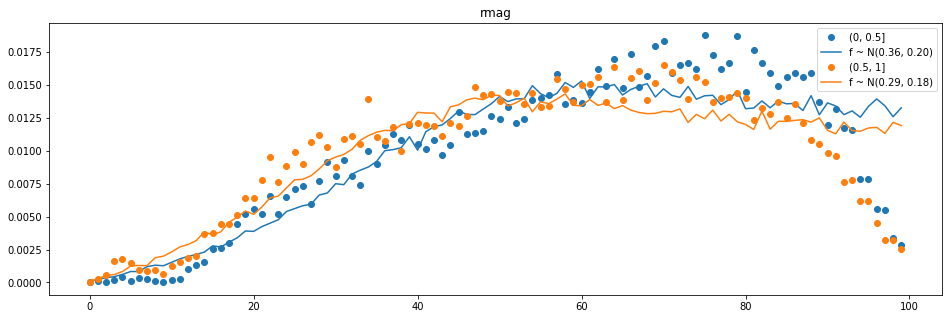

In [251]:
compare_flatness_hist(galaxies_test, "rmag", (0, 1/2, 1))

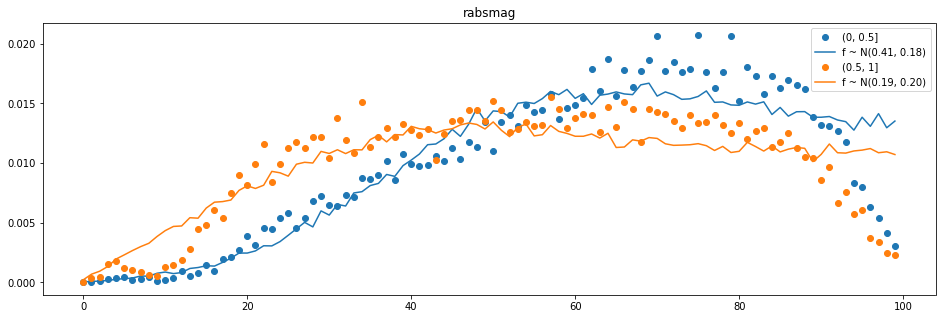

In [245]:
compare_flatness_hist(galaxies_test, "rabsmag", (0, 1/2, 1))

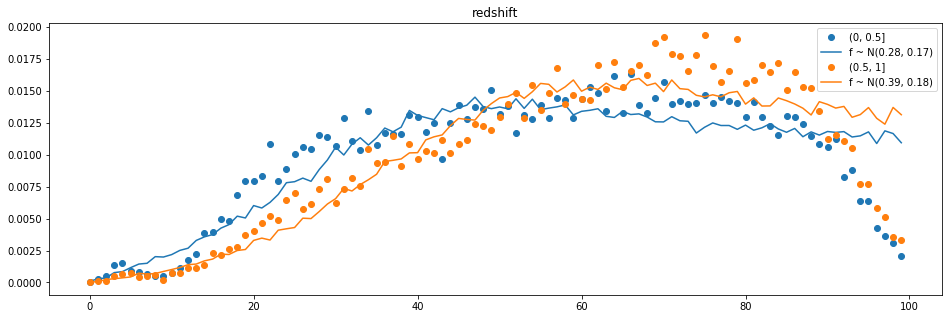

In [246]:
compare_flatness_hist(galaxies_test, "redshift", (0, 1/2, 1))

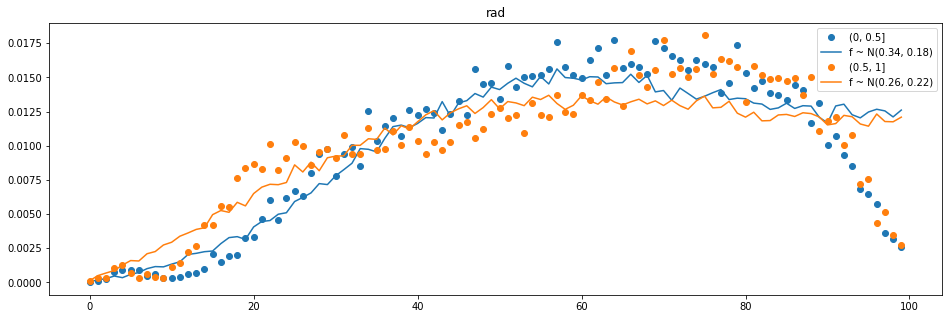

In [247]:
compare_flatness_hist(galaxies_test, "rad", (0, 1/2, 1))

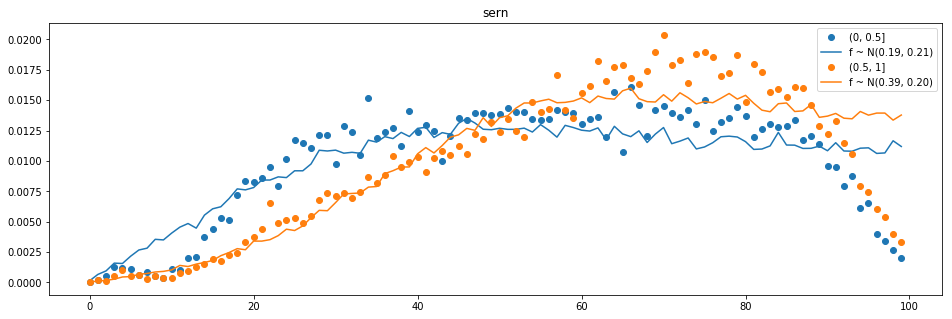

In [248]:
compare_flatness_hist(galaxies_test, "sern", (0, 1/2, 1))